### RDU Text Analysis Notebook

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.stem import *
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import sklearn.feature_extraction.text as text
from wordcloud import WordCloud
from sklearn import decomposition

stop_words = stopwords.words('english')
stemmer=PorterStemmer()
%matplotlib inline

comments=pd.read_csv('C:/Programming/GitHub/RDU_2040_Analysis/Data/reviews_df.csv', encoding="latin-1")
del comments['Unnamed: 0']
comments.head()

,Comment,Date
0,"As a flight attendant, I hope RDU is going to ...",6/16/2015
1,As a Raleigh native who remembers when RDU was...,6/16/2015
2,I recommend that you add a spaceport and docki...,6/16/2015
3,AMS would make me happy lol,6/16/2015
4,I would love a nonstop to CDG or FRA!,6/16/2015


### Analyze number of comments per month

In [2]:
def date_transform(x):
    x_new = dt.datetime.strptime(x, '%m/%d/%Y')
    return 100*x_new.year + x_new.month

In [3]:
comments['Month_Year'] = comments['Date'].map(lambda x: date_transform(x))
comments.head()

,Comment,Date,Month_Year
0,"As a flight attendant, I hope RDU is going to ...",6/16/2015,201506
1,As a Raleigh native who remembers when RDU was...,6/16/2015,201506
2,I recommend that you add a spaceport and docki...,6/16/2015,201506
3,AMS would make me happy lol,6/16/2015,201506
4,I would love a nonstop to CDG or FRA!,6/16/2015,201506


In [4]:
monthly_counts=comments['Month_Year'].value_counts().sort_index()


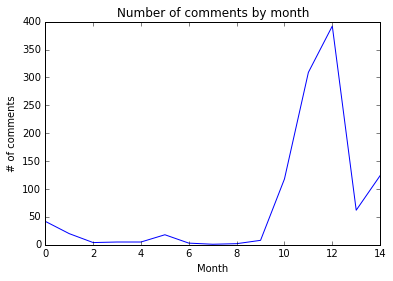

In [5]:
# Plot ROC curve
plt.figure()
plt.plot(np.arange(0,15,1), monthly_counts.values)
plt.xlabel("Month")
plt.ylabel("# of comments")
plt.title("Number of comments by month")
plt.show()

### Prepare Data for analysis
Strip Punctuation, capitalization, and stem words

In [6]:
comments['Comments_new']=[stemmer.stem(re.sub(r'[^\w\s\@]','',comment).lower()) for comment in comments['Comment']]

comments['Comments_new'][1]

'as a raleigh native who remembers when rdu was a tiny terminal that looked like a bus station and you had to wait over an hour to see a single plane take off or land im always pleased andproud these days when i overhear visitors in the terminal saying this is a really nice airport'

### Generate word frequency and wordcloud, excluding those in a stop list

In [7]:
counts=dict()

for comment in comments['Comments_new']:
    for word in comment.split():
        if word not in stop_words:
            counts[word]=counts.get(word,0) + 1

In [8]:
i=0
for key, value in sorted(counts.items(), key=lambda x: x[1], reverse=True):
    i += 1
    print(key, value)
    if i==10:
        break

park 983
area 773
airport 708
crabtree 670
trails 638
rdu 591
land 540
would 497
lake 494
space 407


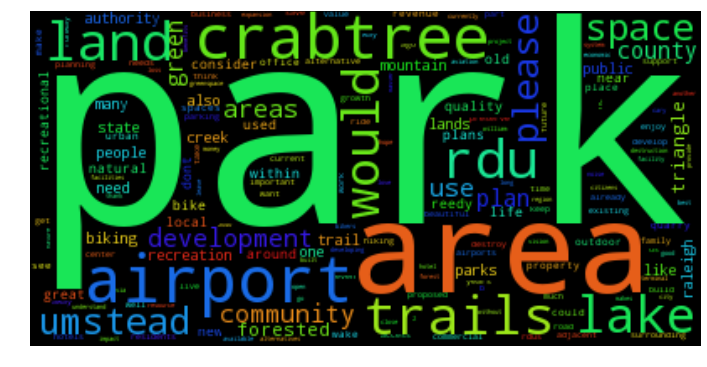

In [9]:
wordcloud = WordCloud().generate_from_frequencies(counts.items())
plt.figure(figsize=(12, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### Generate Docuemnt Term Matrix

In [10]:
#ignore words with frequency of less than 20
vectorizer = text.CountVectorizer(input='files', stop_words='english', min_df=20)
dtm = vectorizer.fit_transform(comments['Comments_new']).toarray()
vocab = np.array(vectorizer.get_feature_names())

#1113 documents, 362 words with counts per document
dtm.shape

(1113, 362)

### Perform Topic Modeling

In [11]:
n_topics=5
n_top_words=5
clf = decomposition.NMF(n_components=n_topics, random_state=12345)
doctopic = clf.fit_transform(dtm)

In [12]:
topic_words=[]
for topic in clf.components_:
    word_idx = np.argsort(topic)[::-1][0:n_top_words]
    topic_words.append([vocab[i] for i in word_idx])
topic_words

[['space', 'forested', 'lands', 'recreation', 'trails'],
 ['airport', 'use', 'land', 'community', 'property'],
 ['park', 'umstead', 'state', 'crabtree', 'land'],
 ['area', 'trails', 'crabtree', 'lake', 'park'],
 ['rdu', 'airport', 'plan', 'new', 'authority']]

### Perform Topic Modeling

In [16]:
topic_class=[]
t=[]
appear=0

i=0
for comment in comments['Comments_new']:
    for i in range(len(topic_words)):
        t=[]
        appear=0
        for word in comment.split():
            if word in topic_words[i]:
                appear +=1
        if appear==0:
            t.append(0)
        else:
            t.append(1)
    #print(t)
    topic_class.append(t)

topic_class[0:5]

[[1], [1], [0], [0], [0]]

In [15]:
word_count=0
topic_in_doc=[]
for comment in comments['Comments_new']:
    word_count=0
    for word in comment.split():
        if word in topic_words[0]:
            word_count +=1
    if word_count==0:
        topic_in_doc.append(0)
    else:
        topic_in_doc.append(1)
topic_in_doc[0:5]

[0, 0, 0, 0, 0]